# MLP para regressão

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import neural_networks as neural_network
import common as com

from sklearn import datasets

np.random.seed(12345)

train_ratio = 0.8
validation_ratio = 0.2

"""
np.random.seed(12345)
x = 2 * np.random.rand(500*2).reshape((500,2)) - 1
y = (np.sin(x[:,0]) ** 2) * (np.cos(x[:,1]) ** 2) + x[:,0] * x[:,1] ** 3
y += np.random.normal(scale=0.01 * np.std(y), size=y.shape)   
import pandas as pd
df = pd.DataFrame(np.hstack((x, y[:,None])))
df.to_csv('data/regression_example.txt', index=False, header=None)
"""

data_table = pd.read_csv('data/regression_example.txt', header=None)
x = data_table.drop(data_table.columns[-1], axis=1).values
y = data_table.iloc[:,data_table.columns[-1]].values  

## Divisão treino/teste e normalização dos dados

In [2]:
normalize_data = True

np.random.seed(12345)

number_train = int(np.ceil(train_ratio*(x.shape[0])))
random_index = np.random.permutation(x.shape[0])
train_index = random_index[:number_train+1]
test_index = random_index[number_train+1:]

x_train = x[train_index]
x_test = x[test_index]
y_train = y[train_index]
y_test = y[test_index]

print("Número de padrões de treinamento: %d" % len(train_index))
print("Número de padrões de teste: %d" % len(test_index))

if normalize_data:

    x_train_mean = np.mean(x_train, axis=0)
    x_train = x_train - x_train_mean
    x_train_std = np.std(x_train, axis=0)
    x_train /= x_train_std
    y_train_mean = np.mean(y_train, axis=0)
    y_train = y_train - y_train_mean
    y_train_std = np.std(y_train, axis=0)
    y_train /= y_train_std

    x_test = (x_test - x_train_mean) / x_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    x = (x - x_train_mean) / x_train_std
    y = (y - y_train_mean) / y_train_std
    
    if x_train.shape[1] == 1:
        fig = plt.figure(figsize=com.figsize)
        plt.plot(x_train, y_train, 'ob', markersize=com.markersize)
        plt.plot(x_test, y_test, 'xb', markersize=com.markersize)
        plt.show()
        xlim = fig.gca().get_xlim() 
        ylim = fig.gca().get_ylim() 

Número de padrões de treinamento: 401
Número de padrões de teste: 99


## Criação do conjunto de validação

In [3]:
number_validation = int(np.ceil(validation_ratio*(x_train.shape[0])))
number_train_validation = x_train.shape[0] - number_validation

random_index = np.random.permutation(x_train.shape[0])
train_index = random_index[:number_train_validation+1]
validation_index = random_index[number_train_validation+1:number_train_validation+number_validation+1]

x_train_validation, x_validation = x_train[train_index], x_train[validation_index]
y_train_validation, y_validation = y_train[train_index], y_train[validation_index]

print("Conjunto de treinamento: %d amostras" % y_train_validation.shape[0])
print("Conjunto de validação: %d amostras" % y_validation.shape[0])

Conjunto de treinamento: 321 amostras
Conjunto de validação: 80 amostras


## Solução via MLP

MSE no treinamento: 4.55e-03
MSE no teste: 7.91e-03


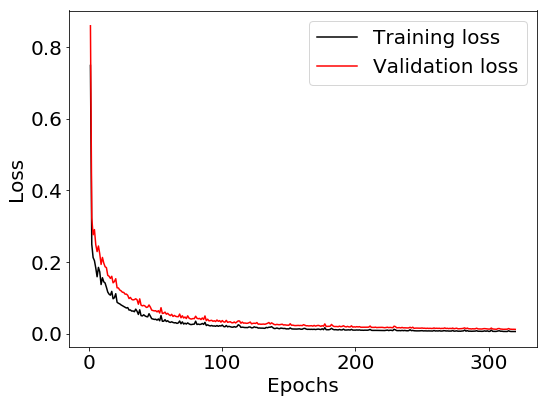

In [28]:
num_hidden_nodes = 100
activation = 'tanh'
output = 'regression'
alpha = 10**-2
mini_batch_size = 32
num_epochs = 10 * mini_batch_size
momentum = 0.9
weight_decay = 0
model_mlp = neural_network.mlp_train(x=x_train_validation, y=y_train_validation,
                                     x_validation=x_validation, y_validation=y_validation,
                                     num_hidden_nodes=num_hidden_nodes, activation=activation, output=output,
                                     num_epochs=num_epochs, alpha=alpha, mini_batch_size=mini_batch_size,
                                     momentum=momentum, weight_decay=weight_decay, compute_loss=True)  

loss_history_mlp = model_mlp['loss_history']
loss_mlp = loss_history_mlp[-1]
validation_loss_history_mlp = model_mlp['validation_loss_history']
valdiation_loss_mlp = validation_loss_history_mlp[-1]

if len(loss_history_mlp) > 1:
    plt.figure(figsize=com.figsize)
    plt.rcParams.update({'font.size': com.fontsize})
    plt.plot(range(1,len(loss_history_mlp)+1), loss_history_mlp, '-k', label='Training loss')
    plt.plot(range(1,len(validation_loss_history_mlp)+1), validation_loss_history_mlp, '-r', label='Validation loss')
    plt.xlabel('Epochs', fontsize=com.fontsize)
    plt.ylabel('Loss', fontsize=com.fontsize)
    plt.legend()

model_mlp = neural_network.mlp_train(x=x_train, y=y_train,
                                     num_hidden_nodes=num_hidden_nodes, activation=activation, output=output,
                                     num_epochs=num_epochs, alpha=alpha, mini_batch_size=mini_batch_size,
                                     momentum=momentum, weight_decay=weight_decay, compute_loss=False)    
 
pred_train = neural_network.mlp_predict(model_mlp, x_train)
mse_train = np.mean((y_train - pred_train)**2)  
pred_test = neural_network.mlp_predict(model_mlp, x_test)
mse_test = np.mean((y_test - pred_test)**2)   

print("MSE no treinamento: %.2e" % mse_train)
print("MSE no teste: %.2e" % mse_test)

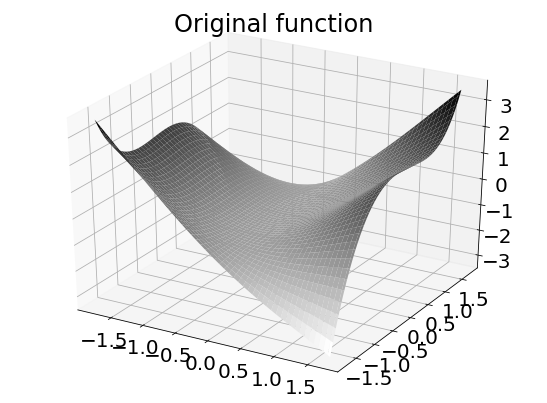

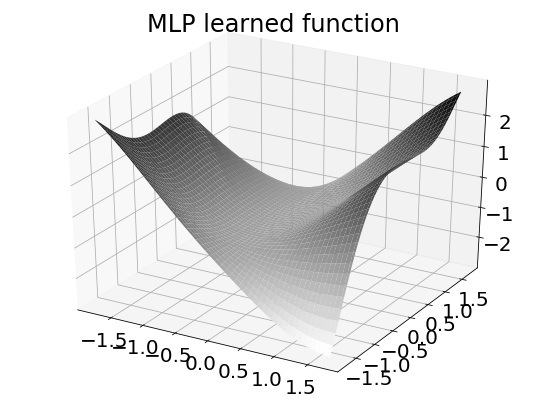

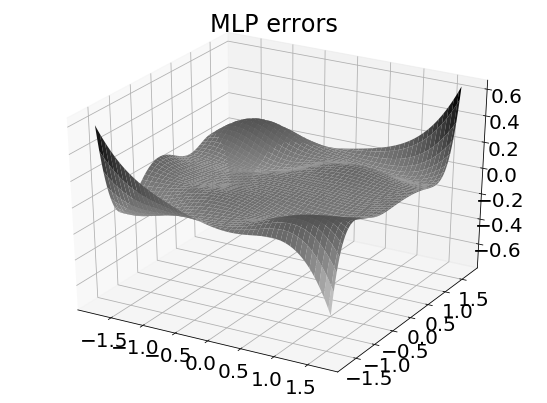

In [29]:
def regression_example(x0, x1):
    if normalize_data:
        x0 = x0 * x_train_std[0] + x_train_mean[0]
        x1 = x1 * x_train_std[1] + x_train_mean[1]
    y = (np.sin(x0) ** 2) * (np.cos(x1) ** 2) + x0 * x1 ** 3
    if normalize_data:
        y = (y - y_train_mean) / y_train_std
    return y

def regression_example_grid(x):
    x0 = x[0]
    x1 = x[1]            
    z = x0.copy()    
    for i in range(x0.shape[0]):
        for j in range(x0.shape[1]):
            z[i,j] = regression_example(x0[i,j], x1[i,j])
    return z

def mlp_grid(x):
    x0 = x[0]
    x1 = x[1]            
    z = x0.copy()    
    for i in range(x0.shape[0]):
        for j in range(x0.shape[1]):
            z[i,j] = neural_network.mlp_predict(model_mlp, np.array([x0[i,j], x1[i,j]]).reshape((1,2)))    
    return z

x_grid = np.meshgrid(np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100),
                     np.linspace(np.min(x[:,1]), np.max(x[:,1]), 100))
y_grid = regression_example_grid(x_grid)
plt.figure(figsize=com.figsize)
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid[0], x_grid[1], y_grid, cmap='binary')
plt.title('Original function')
#plt.savefig('figs/linear_reg_surf.png', dpi=com.dpi)
plt.show()

pred_grid = mlp_grid(x_grid)
plt.figure(figsize=com.figsize)
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid[0], x_grid[1], pred_grid, cmap='binary')
plt.title('MLP learned function')
#plt.savefig('figs/linear_reg_surf.png', dpi=com.dpi)
plt.show()      

plt.figure(figsize=com.figsize)
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid[0], x_grid[1], y_grid - pred_grid, cmap='binary')
plt.title('MLP errors')
#plt.savefig('figs/linear_reg_surf.png', dpi=com.dpi)
plt.show()   